Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality, Duration And Cyclic Time

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
############################
#SAMPLE
dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday', 'weekend']].copy()
df = dfa.sample(n=10000, random_state=1).copy()

#df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekday']].copy()

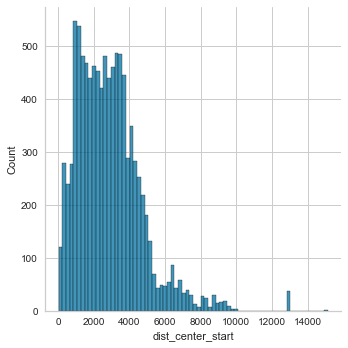

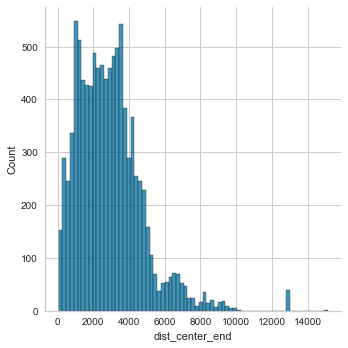

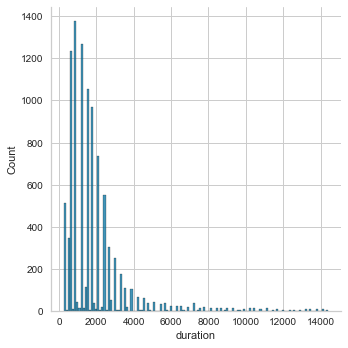

In [6]:
# univariate distribution of numeric variables
for column in df[['dist_center_start','dist_center_end', 'duration']].columns:
    sns.displot(df, x=column)

### Data transformation

In [7]:
# convert duration into minutes
df['duration'] = df['duration'] / 60

# quantile transformation for right skewed numeric features
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df['dist_center_start_quant'] = quantile_transformer.fit_transform(df[['dist_center_start']])
df['dist_center_end_quant'] = quantile_transformer.fit_transform(df[['dist_center_end']])
df['duration_quant'] = quantile_transformer.fit_transform(df[['duration']])

#quantile_transformer.quantiles_


# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (True):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df.columns

Index(['id', 'vehicleType', 'dist_center_start', 'dist_center_end', 'duration',
       'hour', 'weekday', 'weekend', 'dist_center_start_quant',
       'dist_center_end_quant', 'duration_quant', 'sin_hour', 'cos_hour',
       'sin_weekday', 'cos_weekday'],
      dtype='object')

5.19933758270342
-5.199337582605575
5.19933758270342
-5.199337582605575
5.19933758270342
-5.199337582605575


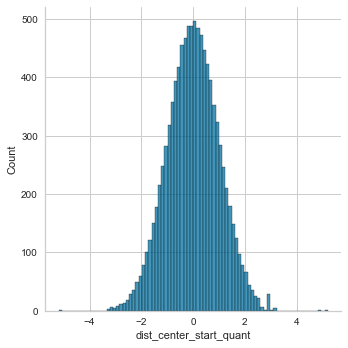

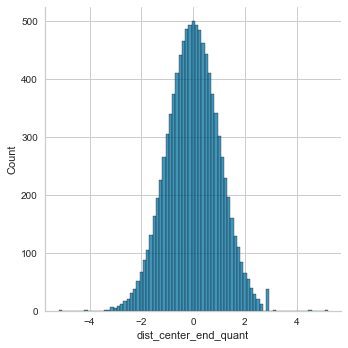

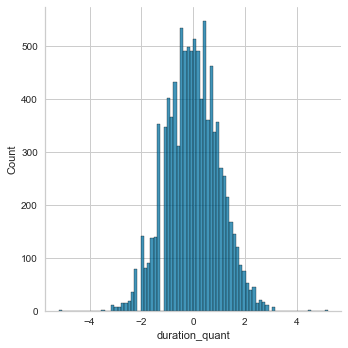

In [8]:
# univariate distribution of quantile transformed numeric variables
for column in df[['dist_center_start_quant','dist_center_end_quant', 'duration_quant']].columns:
    sns.displot(df, x=column)
    print(df[column].max())
    print(df[column].min())

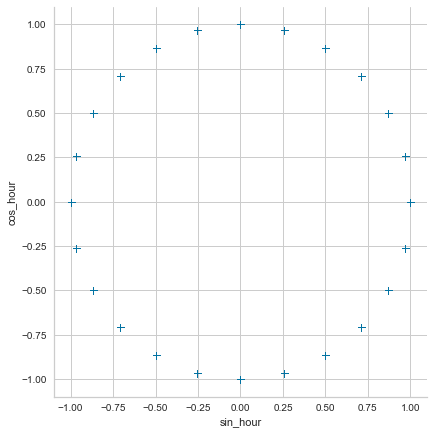

In [9]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

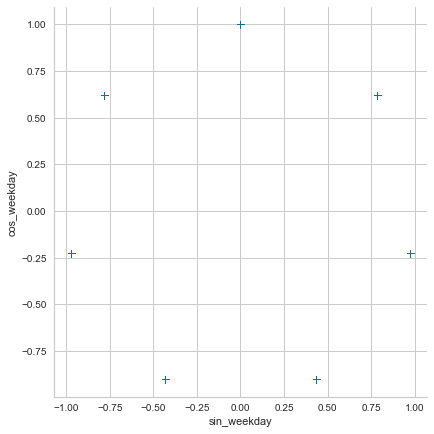

In [10]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

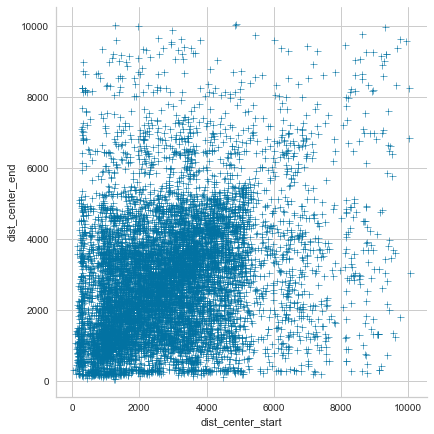

In [11]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)
#df = df.drop(df[(df['dist_center_start']>11000)&(df['dist_center_end']>11000)].index, inplace=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

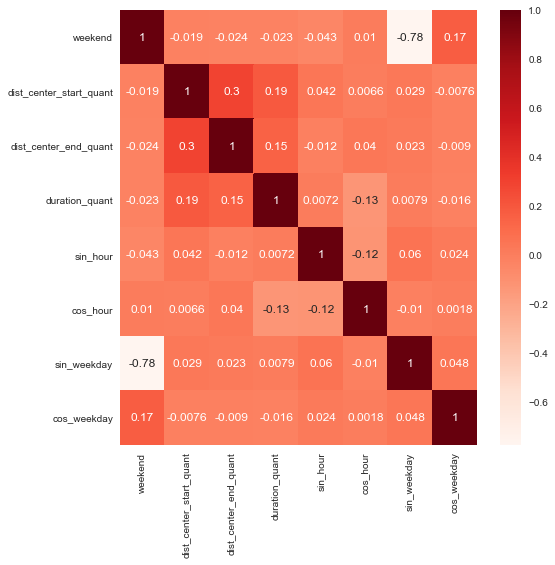

In [12]:
#Using Pearson Correlation
plt.figure(figsize=(8,8))
cor = df[['weekend', 'dist_center_start_quant',
       'dist_center_end_quant', 'duration_quant', 'sin_hour', 'cos_hour',
       'sin_weekday', 'cos_weekday']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Feature scaling

5.19933758270342

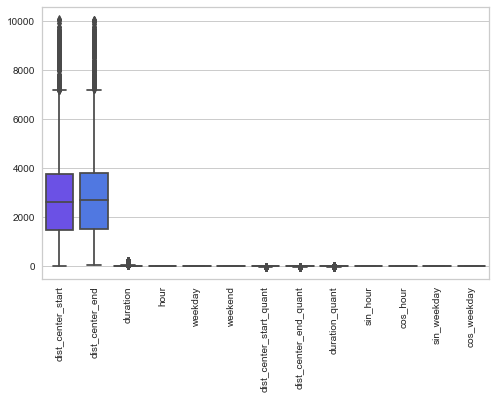

In [13]:
# look at feature skewness
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)
df['duration_quant'].max()

In [14]:
# normalize features to get same range as sin and cos values
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
normalizing = False
if (normalizing):
    #dfnorm = df[['dist_center_start','dist_center_end', 'duration']].copy()

    dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

    # column names
    names = dfnorm.columns
    # create scaler object
    scaler = StandardScaler()
    # fit data on scaler object
    dfnorm = scaler.fit_transform(dfnorm)
    dfnorm = pd.DataFrame(dfnorm, columns=names)
    # normalize data
    dfnorm = normalize(dfnorm) 
  
    # Converting the numpy array into a pandas DataFrame 
    normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour','sin_weekday','cos_weekday', 'weekend']].copy()
if (normalizing):
    scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
#else:
    #scaled_df = pd.concat([scaled_df, df[['dist_center_start','dist_center_end', 'duration','weekend']]], axis=1)
    
    
# assign weight to variables to compensate for double appearance of time related features
feature_weight = 3
feature_weight2 = 3
scaledivide = df['duration_quant'].max()
#scaledivide = 5.19933758270342

scaled_df['duration'] = df['duration_quant'] / scaledivide * feature_weight2
scaled_df['dist_center_start'] = df['dist_center_start_quant'] / scaledivide * feature_weight
scaled_df['dist_center_end'] = df['dist_center_end_quant'] / scaledivide * feature_weight


scaled_df['weekend'] = (scaled_df['weekend'] - 0.5)

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.516982
cos_hour             0.381723
sin_weekday          0.504301
cos_weekday          0.489658
weekend              0.206622
duration             0.325491
dist_center_start    0.323014
dist_center_end      0.322009
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'sin_weekday'),
  Text(3, 0, 'cos_weekday'),
  Text(4, 0, 'weekend'),
  Text(5, 0, 'duration'),
  Text(6, 0, 'dist_center_start'),
  Text(7, 0, 'dist_center_end')])

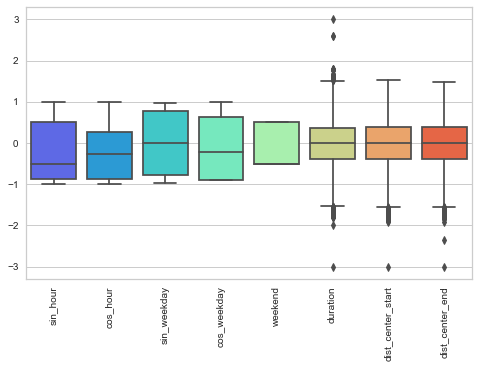

In [15]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

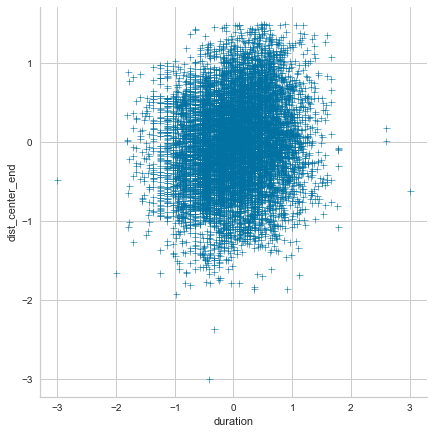

In [16]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="duration", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=6, aspect=1)

### Cluster tendency

In [18]:
# calculate hopkins statistics on subset
from pyclustertend import hopkins
#hopkins(scaled_df, 10000)

### Clustering trip types via k-means and parameter selection

#### Parameter selection / clustering performance evaluation

In [19]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

max_num_cluster = 40

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  25101.559076891717
silhouette:  0.17696280298237063
calinski harabasz:  2115.846243117
davies bouldin:  2.118119910565893
3.862182140350342
3
inertia:  21341.159547190196
silhouette:  0.19037093184313456
calinski harabasz:  2118.0922308602258
davies bouldin:  1.8454260718566367
3.6063051223754883
4
inertia:  19322.156775475487
silhouette:  0.1888289713933783
calinski harabasz:  1904.9026802523276
davies bouldin:  1.6927170069173736
3.9145262241363525
5
inertia:  17949.433668464786
silhouette:  0.18751967768472227
calinski harabasz:  1727.388836175306
davies bouldin:  1.7299361456105935
3.9022417068481445
6
inertia:  16779.313021949543
silhouette:  0.18746318349968835
calinski harabasz:  1616.431083095077
davies bouldin:  1.835122477855364
4.248414993286133
7
inertia:  15968.5259235965
silhouette:  0.1802042197600789
calinski harabasz:  1499.181308220992
davies bouldin:  1.8268684965146043
8.016670942306519
8
inertia:  15242.82480218086
silhouette:  0.18310248391936218
calin

#### Elbow method

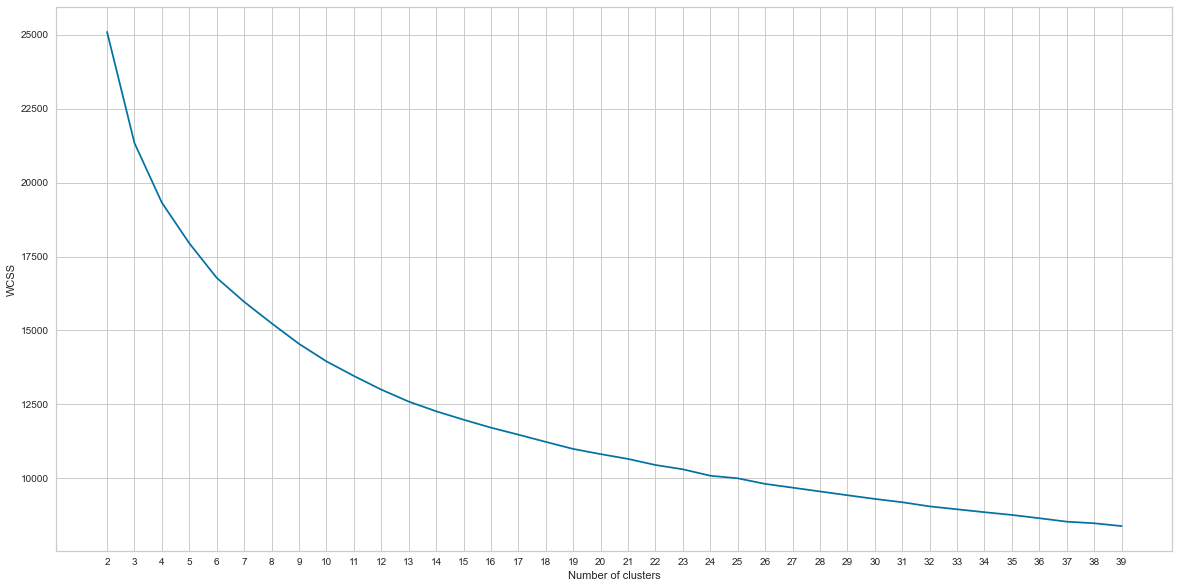

In [20]:
# plot wcss for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

#### Silhouette coefficient

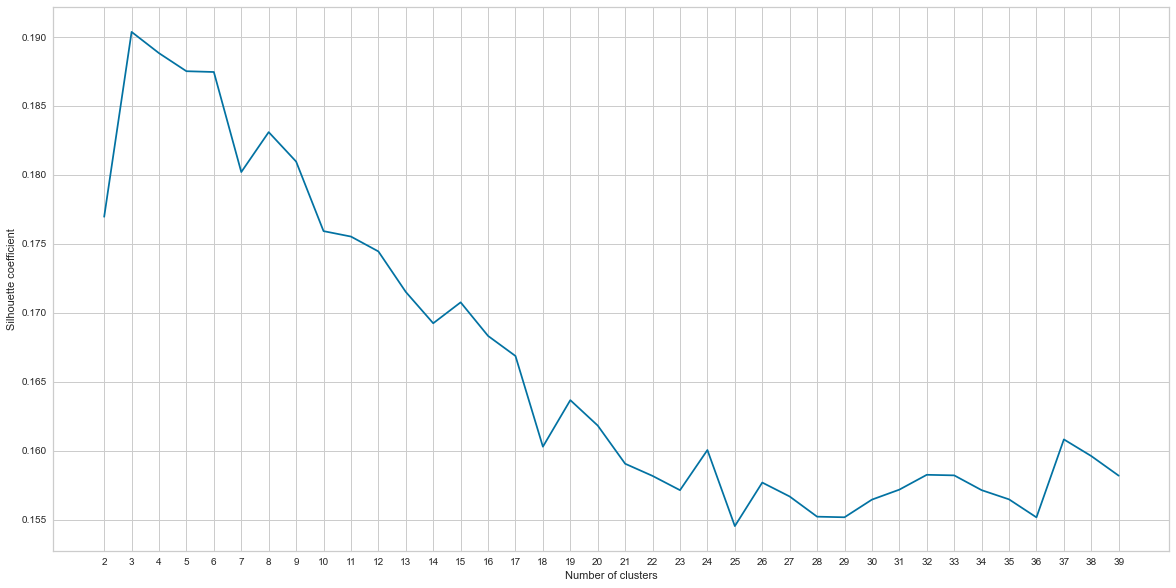

In [21]:
# plot silhouette coefficients for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

In [22]:
# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,40), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

#### Calinski Harabasz score

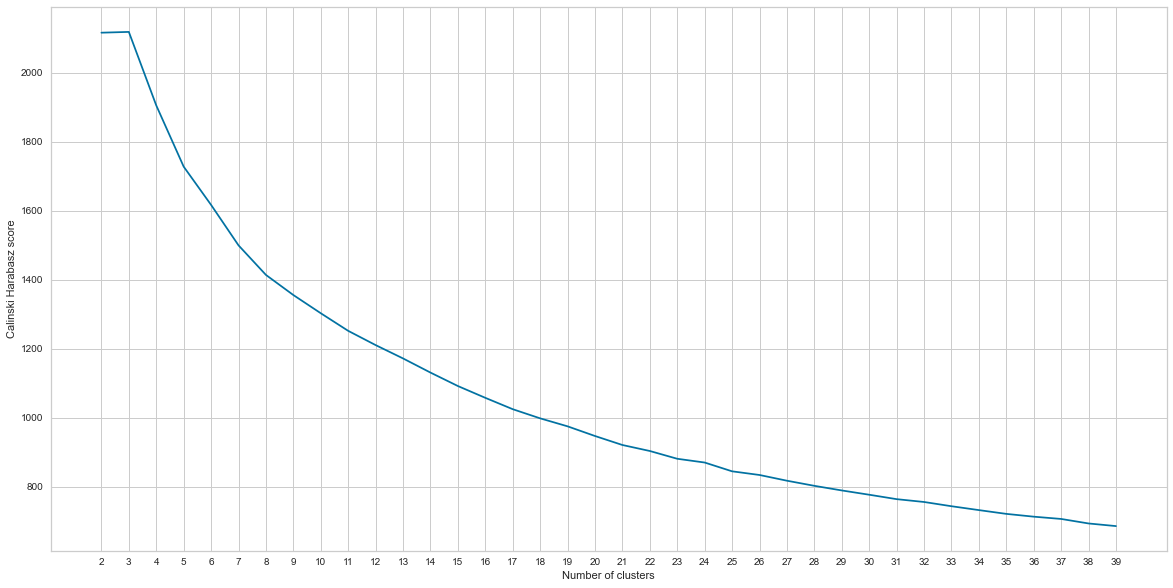

In [23]:
# plot Calinski Harabasz score for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()

#### Davies Bouldin index

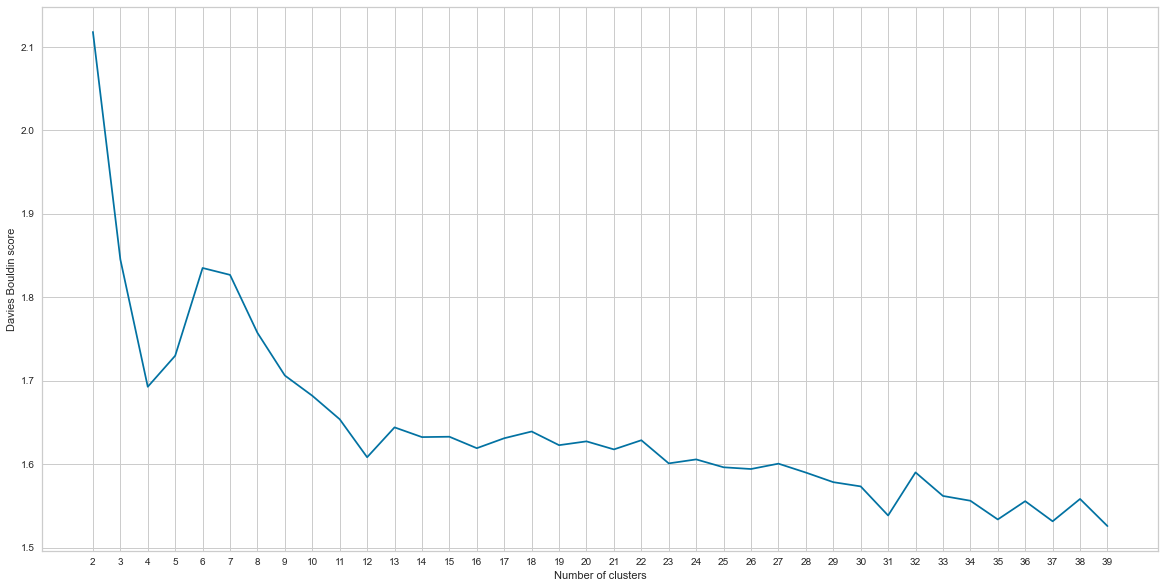

In [24]:
# plot Davies Bouldin scores for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()

#### K-means with selected parameter

In [25]:
# cluster data for the chosen number of clusters
k = 21

kmeans = KMeans(n_clusters=k,  n_init=20, random_state=0).fit(scaled_df)

clustered_data = df.copy()

clustered_data['cluster'] = kmeans.fit_predict(scaled_df)


clustered_data

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekday,weekend,dist_center_start_quant,dist_center_end_quant,duration_quant,sin_hour,cos_hour,sin_weekday,cos_weekday,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,2,0,-0.372918,0.331166,-0.212353,7.071068e-01,0.707107,0.974928,-0.222521,5
1,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,4,0,1.176703,-0.620410,1.202347,-8.660254e-01,-0.500000,-0.433884,-0.900969,19
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,5,1,0.976119,-1.658764,0.851675,-8.660254e-01,0.500000,-0.974928,-0.222521,12
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,3,0,-0.267689,0.072075,0.389783,-2.588190e-01,-0.965926,0.433884,-0.900969,0
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,5,1,-0.618059,0.116099,0.184203,-8.660254e-01,0.500000,-0.974928,-0.222521,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917,YmlrZTo6dGllcjo6MWNlOTg2MjctNGFkMC00YjZjLWFmND...,scooter,1147,1767,9.983333,13,4,0,-0.970316,-0.525708,-1.283836,-2.588190e-01,-0.965926,-0.433884,-0.900969,2
9918,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA3NTc0,car,3366,6197,10.016667,10,4,0,0.403966,1.596716,-0.995858,5.000000e-01,-0.866025,-0.433884,-0.900969,0
9919,YmlrZTo6dGllcjo6N2FlMTY5ODUtOWRiZS00ZTU3LTg1OT...,scooter,4242,3189,4.983333,15,6,1,0.915459,0.269019,-2.183092,-7.071068e-01,-0.707107,-0.781831,0.623490,1
9920,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIyMjE2,car,5956,4166,45.016667,12,3,0,1.555836,0.842905,1.066304,1.224647e-16,-1.000000,0.433884,-0.900969,0


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

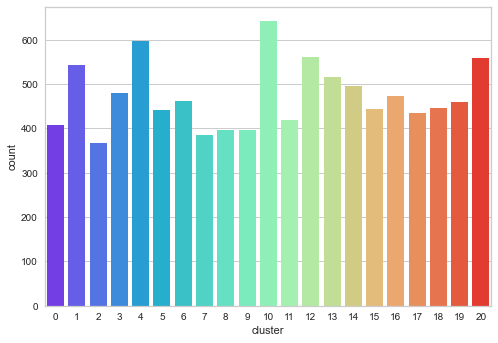

In [26]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Cluster magnitude

In [27]:

#distances = kmeans.fit_transform(scaled_df)
#variance = 0
#i = 0
#for label in kmeans.labels_:
#    variance = variance + distances[i][label]
#    i = i + 1
#variance

#for kmeans.labels_
#inertia_0

#### Cardinality vs magnitude

#### Attribute table

In [28]:
interpret_df = clustered_data[['dist_center_start','dist_center_end','duration', 'weekend','cluster']].copy()
interpret_df = interpret_df.groupby(['cluster']).mean()


time_df = clustered_data[['weekday','hour','cluster']].copy()

dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
time_df = time_df.join(pd.get_dummies(time_df['weekday']))
time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

interpret_df = interpret_df.join(time_df)

interpret_df['morning 6-12'] = interpret_df[6] + interpret_df[7] + interpret_df[8] + interpret_df[9] + interpret_df[10] + interpret_df[11] + interpret_df[12]
interpret_df['evening 13-20'] = interpret_df[14] + interpret_df[15] + interpret_df[16] + interpret_df[17] + interpret_df[18] + interpret_df[19] + interpret_df[20]


pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret_df.T.round(2)
#interpret_df.T.round(2).to_excel("InterpretClusters.xlsx")  

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
dist_center_start,3605.97,4564.32,1445.38,1658.55,2598.77,3537.95,3431.42,1314.54,2603.20,1500.47,3607.88,2060.31,1915.52,3801.80,4057.46,2224.07,3761.46,1374.96,2412.85,3682.63,3037.34
dist_center_end,3764.54,3641.00,1792.04,1758.66,3039.78,2511.61,3880.65,1322.30,3038.05,1370.02,3563.57,1794.75,2189.22,3173.15,3616.09,3202.10,3872.55,1485.00,2922.88,3412.90,3440.90
duration,17.93,32.08,19.69,17.58,19.98,42.50,34.42,14.49,18.18,14.79,44.79,19.05,27.19,26.96,30.93,53.07,46.80,16.39,18.18,49.83,45.64
weekend,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
0 Monday,0.00,0.00,0.00,53.33,0.00,0.00,61.26,0.00,2.27,36.78,0.00,0.00,0.00,0.00,59.19,0.00,0.00,0.00,0.00,0.00,50.18
1 Tuesday,0.98,0.00,0.00,46.67,0.00,22.22,38.74,0.00,33.84,50.13,0.00,0.00,0.00,0.00,40.81,0.00,0.00,0.00,0.00,0.00,49.82
2 Wednesday,35.54,0.00,0.00,0.00,0.00,75.51,0.00,0.00,63.89,13.10,48.91,0.00,0.00,0.00,0.00,0.00,0.00,53.79,0.00,0.00,0.00
3 Thursday,55.15,0.00,0.27,0.00,38.26,2.27,0.00,0.00,0.00,0.00,51.09,53.22,0.00,0.00,0.00,0.00,47.25,46.21,0.00,0.00,0.00
4 Friday,8.33,0.00,99.73,0.00,61.74,0.00,0.00,0.00,0.00,0.00,0.00,46.78,0.00,0.00,0.00,0.00,52.75,0.00,0.00,100.00,0.00
5 Saturday,0.00,58.12,0.00,0.00,0.00,0.00,0.00,60.52,0.00,0.00,0.00,0.00,67.20,59.03,0.00,59.01,0.00,0.00,56.60,0.00,0.00


C:\Users\User_Vratar\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


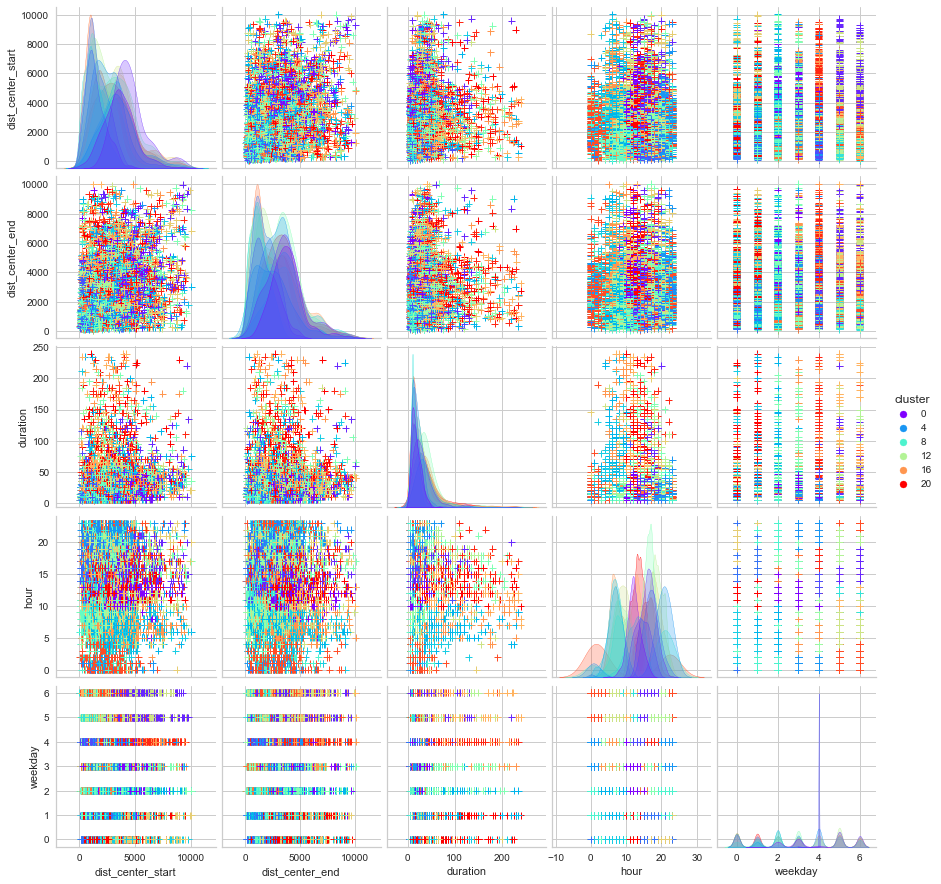

In [29]:
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','weekday','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

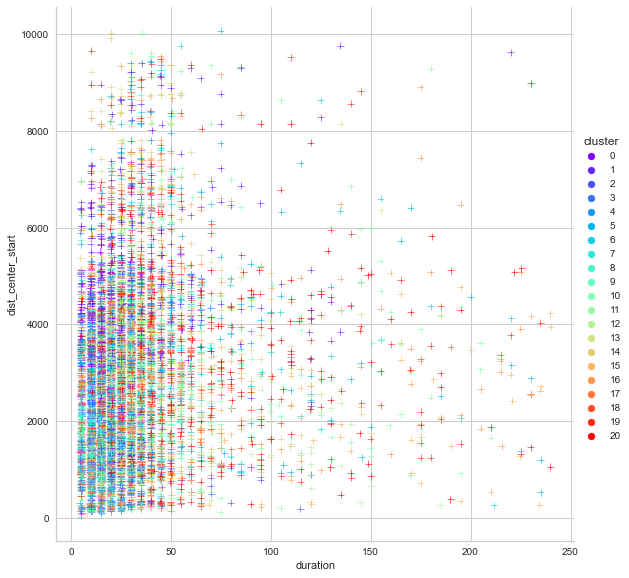

In [30]:
# plot cluster results
g = sns.relplot(x="duration", y="dist_center_start", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

<AxesSubplot:xlabel='weekday', ylabel='count'>

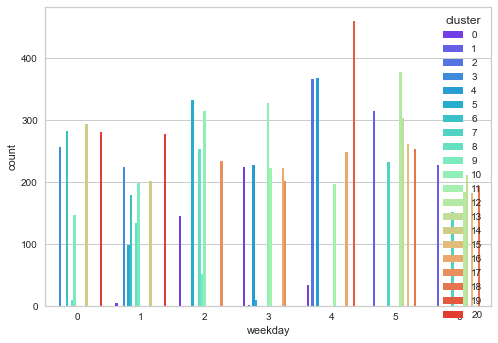

In [31]:
sns.countplot(x="weekday", data=clustered_data, hue='cluster', palette='rainbow')

In [32]:
sampleTSNE = scaled_df.sample(n=5000, random_state=1)
# cluster data for the chosen number of clusters
k = 21
k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
clusters = k_means_new.fit_predict(sampleTSNE)
sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,:-1]
##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.027s...
[t-SNE] Computed neighbors for 5000 samples in 1.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.564921
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.709381
[t-SNE] KL divergence after 5000 iterations: 0.980632


array([[  9.443697 ,  59.536366 ],
       [ 28.281195 ,  69.8996   ],
       [  9.752518 , -17.565926 ],
       ...,
       [ -1.6013297,  78.2848   ],
       [ 32.71288  , -32.669476 ],
       [-13.046142 ,   8.264047 ]], dtype=float32)

In [33]:
tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = clusters
tsne_cluster.columns = ['x1','x2','cluster']

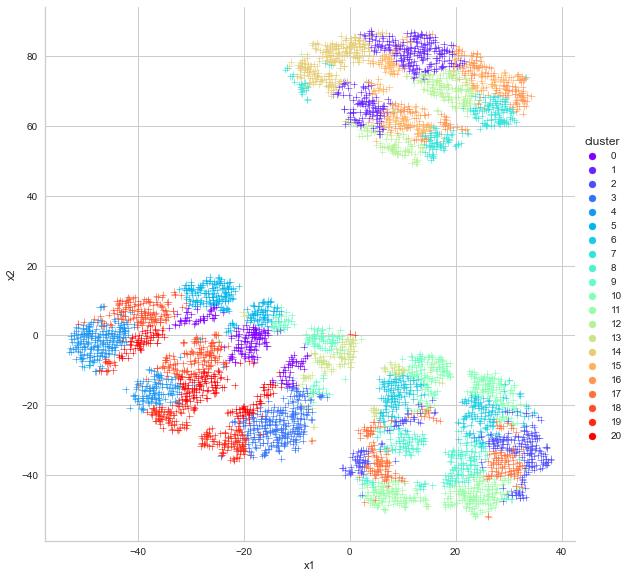

In [34]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=8, aspect=1)

### Distribution of trip types among mobility modes

In [35]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [36]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,3.477537
1,6.589018
2,2.113145
3,2.362729
4,5.224626
5,6.039933
6,5.890183
7,1.014975
8,3.261231


In [37]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,3.645008
1,3.328051
2,4.595880
3,7.923930
4,5.705230
5,4.754358
6,3.961965
7,3.961965
8,3.961965


In [38]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,5.364218
1,3.809814
2,6.430966
3,8.777812
4,7.497714
5,1.462969
6,2.529717
7,9.113075
8,5.333740
